# Predicting hospital admission at emergency department triage

**Main statement**
Using machine learning, how might we predict the patient admission into the hospital in the emergency department to provide better information that helps the different stakeholders make better decisions.


### Notebook Content

- Baseline Model
    - Logistic Regression
- Class imabalance
    - Downsampling / Imbalance learn
- Feature selection
    - Variance Threshold
    - K-best
    - PCA
- Hiperparameter Optimization and Cross validation
    - Logistic Regression
    - Decision Trees
    - Random forest
    - XGBoost
- Pipelines
    - Logistic Regression
    - Random forest
    - XGBoost


This notebook builds upon the previous one, which documented the entire process of data exploration and preprocessing. It will be using the 'processed_df' dataframe in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
from scipy import stats

In [2]:
# Load the data
df_processed_original = pd.read_csv('/Users/ccalderon/Documents/Repositories/df_processed.csv')


In [3]:
# Shape
print(f'The dataframe has {df_processed_original.shape[0]} rows and {df_processed_original.shape[1]} columns.')


The dataframe has 534730 rows and 602 columns.


**Take only 10% of the data to make faster run the models, once the notebook will be completed run everything in SageMaker using the whole dataframe**
Remember change the name of the original df_processed when will be the moment to run the notebook with the whole quantity of data.

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into sample and remainder sets, with stratification based on the class labels
df_processed, remainder_df = train_test_split(df_processed_original, test_size=0.9, stratify=df_processed_original['disposition'], random_state=1)



In [5]:
df_processed.shape

(53473, 602)

# Modeling

The task of predicting whether a patient will be admitted or discharged is a binary classification problem, which involves making one of two possible predictions.

There are several machine learning models that can be used to solve binary classification problems like predicting whether a patient will be admitted or discharged. Some popular ones are:

- Logistic Regression
- Decision Trees
- Random Forests
- Support Vector Machines (SVM)
- Naive Bayes
- Neural Networks (e.g., Multi-layer Perceptron)

The choice of model depends on various factors such as the size of the dataset, the complexity of the problem, the interpretability of the model, and the desired level of accuracy. 

It is usually a good practice to try out multiple models and compare their performance to select the best one for the problem at hand.

The df_processed contains more than 500000 rows and more than 600 features (good mix between categorical and numerical columns) , it is a large dataset that could be computationally expensive to train and test depending the model chose. Based on this, to this case it will be explored the following models:

- Logistic Regression: commonly used model for binary classification problems. With a high number of columns there may be many potential interactions and non-linearities among the features. That being said, it's always worth trying logistic regression as a baseline model for comparison purposes, especially if the dataset has a small number of informative features. This model is simple, interpretable, and computationally efficient, and it can serve as a good starting point for model selection.

- Decision Trees: partitioning the data into multiple subsets based on specified cutoff values in the features this model predicts the outcome for each leaf node by using the average outcome of the training data within that particular node.

- Random Forest: This model is known to perform well with large datasets and high-dimensional feature spaces. It can handle a mix of categorical and numerical features, and it's relatively easy to interpret.

- Gradient Boosting (XGBoost): This model is also known to perform well with large datasets and can handle a mix of categorical and numerical features. It's more complex than Random Forests, but it can achieve better performance with careful tuning because is more likely to over-fitting.


## Logistic Regression Model

Previous Assumptions:
- Observations are independent of each other.
- The relationship between the independent variables and the log odds of the binary outcome is linear.
- There is no perfect multicollinearity between the independent variables.
- There is a large enough sample size to provide reliable estimates of the coefficients.
- Should not be outliers in the data.
- The errors (residuals) are independent of each other.


In [6]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53473 entries, 399260 to 378058
Columns: 602 entries, disposition to whtblooddx
dtypes: float64(202), int64(400)
memory usage: 246.0 MB


In [7]:
# Define the predictor variables
X = df_processed.drop(columns=['disposition'],axis=1).copy()

# Define the target variable
y = df_processed['disposition']

In [8]:
from sklearn.model_selection import train_test_split

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                 test_size=0.3, 
                                                 random_state=3, 
                                                 stratify=y)

In [9]:
# Logistic regression baseline model
from sklearn.linear_model import LogisticRegression

baseline_logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
baseline_logreg.fit(X_train, y_train)
predictions_train = baseline_logreg.predict(X_train)
predictions_test = baseline_logreg.predict(X_test)
blg_train_accuracy = baseline_logreg.score(X_train, y_train)
blr_test_accuracy = baseline_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {blg_train_accuracy}")
print(f"Baseline_logreg test accuracy: {blr_test_accuracy}")

Baseline_logred train accuracy: 0.8599022200849563
Baseline_logreg test accuracy: 0.8488966463034534


In [10]:
# Logistic Regression Coeficients (remove # too se the coeficients)
# baseline_logreg.coef_

In [11]:
# Define the feature_label and its coefficient
column_labels = X_train.columns.tolist()

# Squeeze function to convert the numpy array into a 1-dimensional array
coef = baseline_logreg.coef_.squeeze().tolist()

In [12]:
# Create a dictionary with column_labels as key and coeficients as values

lg_predictors= dict(zip(column_labels, coef))
lg_predictors

{'dep_A': -0.09702196462705877,
 'dep_B': -0.06921673476596821,
 'dep_C': -0.5357651515540295,
 'Female': -0.47144610924345054,
 'Male': -0.23055774170249868,
 'Divorced': 0.07621780218489932,
 'Married': -0.0013429444762703148,
 'Single': -0.026559367773441412,
 'Widowed': -0.01935099463122749,
 'Full Time': -0.06466561101754087,
 'Not Employed': 0.16463754237348863,
 'Commercial': 0.40984248360103015,
 'Medicaid': 0.1853126936417625,
 'Medicare': 0.30875635647591604,
 'Car': -0.3524484322688748,
 'Walk-in': -0.29651053153345275,
 'ambulance': 0.06326993292158946,
 'April': -0.1630663042908083,
 'August': -0.018970829360427106,
 'December': -0.040140243746182705,
 'February': 0.0021463275576474286,
 'January': -0.13800146350391498,
 'July': -0.10397962616270637,
 'June': -0.06298995711550127,
 'March': -0.04737687786072833,
 'May': -0.08902361017367792,
 'November': -0.11823762655598906,
 'October': 0.04247837476575221,
 'September': 0.035157985501422066,
 'Friday': -0.062939254118939

In [13]:
# Top most predictive features by coeficient

sorted_predictors = sorted(lg_predictors.items(), key=lambda x: x[1], reverse=True)
sorted_predictors

[('esi_1', 2.5015479570387558),
 ('cc_respiratorydistress', 2.120106595338743),
 ('cc_strokealert', 1.7590132637562228),
 ('cc_feverimmunocompromised', 1.6717565166696045),
 ('cc_psychoticsymptoms', 1.5651823362114734),
 ('cc_cellulitis', 1.5223396234124298),
 ('cc_fever-75yearsorolder', 1.4687432323025962),
 ('cc_extremityweakness', 1.3511830202982338),
 ('cc_fulltrauma', 1.2288736124728168),
 ('meds_contraceptives', 1.2007503038402996),
 ('meds_biologicals', 1.1770320591898082),
 ('acutphanm', 1.171997032406671),
 ('cc_neurologicproblem', 1.1379631730781556),
 ('cc_follow-upcellulitis', 1.0858908817427098),
 ('cc_fever-9weeksto74years', 1.0397121718028273),
 ('cc_abdominaldistention', 1.0171489531928646),
 ('cc_woundinfection', 1.008627503610258),
 ('cc_pain', 0.9785301439769255),
 ('cc_multiplefalls', 0.944382800131184),
 ('nervcongan', 0.919203045407405),
 ('cc_alteredmentalstatus', 0.9161481966948598),
 ('esi_2', 0.9142344553010794),
 ('cc_chills', 0.911422742653066),
 ('cc_dehydr

It looks like the model is performing really well, 85% accuracy. However, imbalanced data forces us to rely on other evaluation metrics than accuracy: precision, recall, F1 score, and area under the ROC curve to evaluate our model.

Class imbalance can cause an issue when training models. Consider the cost function when the model is fitting on the training data. The cost function is going to be biased towards the majority class and will result in a model that doesn't learn enough about the minority class.

Lets see the confusion matrix to evaluate other scores:

In [14]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Discharge", "Predicted Admitted"],
    index=["True Discharge", "True Admitted"]
)

display(cf_df)

,Predicted Discharge,Predicted Admitted
True Discharge,10370,730
True Admitted,1694,3248


- True Discharge: 104,335 patients were actually discharged and the model correctly predicted that they would be discharged.
- False Admitted: 6,667 patients were actually discharged but the model incorrectly predicted that they would be admitted.
- False Discharge: 16,558 patients were actually admitted but the model incorrectly predicted that they would be discharged.
- True Admitted: 32,859 patients were actually admitted and the model correctly predicted that they would be admitted.

In summary, the model correctly classified 137,194 patients (104,335 true discharge and 32,859 true admitted) and incorrectly classified 23,225 patients (6,667 false admitted and 16,558 false discharge).

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90     11100
           1       0.82      0.66      0.73      4942

    accuracy                           0.85     16042
   macro avg       0.84      0.80      0.81     16042
weighted avg       0.85      0.85      0.84     16042



Precision: the precision for class 0.0 is 0.86, which means that 86% of the instances that the model predicted as 0.0 were actually 0.0. Similarly, the precision for class 1.0 is 0.83, indicating that 83% of the instances that the model predicted as 1.0 were actually 1.0.

Recall: the recall for class 0.0 is 0.94, which means that 94% of the actual instances that were 0.0 were correctly predicted by the model. **The recall for class 1.0 is 0.66, indicating that 66% of the actual instances that were 1.0 were correctly predicted by the model**.

F1-score: F1-score for class 0.0 is 0.90, and the F1-score for class 1.0 is 0.74. The weighted average F1-score is 0.85, indicating that the model performed reasonably well overall.

## Class imbalance

To correct the imbalance in this case the approach is going to be downsampling. (A very important note here is that which ever approach will be applied should only be done to the training data, the test data should remain untouched and have class imbalance consistent with what you would expect the real world to be.)

### Downsampling

Downsampling is a method for reducing the size of a dataset by randomly removing observations from the majority class, which can help to balance the class distribution in a binary classification problem. This can be useful when the dataset is imbalanced and the minority class is underrepresented.

In [16]:
from sklearn.utils import resample

print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=123)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine downsample with original data
X_train_bal2 = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_bal2 = np.hstack((y_train[y_train == 1], y_downsampled))

# Convert the X variable numpy array into a dataframe
X_train_bal2 = pd.DataFrame(X_train_bal2, columns=X.columns)

Number of class 0 examples before: 25901
Number of class 0 examples after: 11530


Let's try again the logistic regression model using the downsampled data:

In [17]:
# Logistic regression after downsampling

resample_logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
resample_logreg.fit(X_train_bal2, y_train_bal2)
predictions_train = resample_logreg.predict(X_train_bal2)
predictions_test_ds = resample_logreg.predict(X_test)
resample_train_accuracy = resample_logreg.score(X_train_bal2, y_train_bal2)
test_accuracy = resample_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {resample_train_accuracy}")
print(f"Baseline_logreg test accuracy: {test_accuracy}")

Baseline_logred train accuracy: 0.8346053772766695
Baseline_logreg test accuracy: 0.8300710634584216


Quite similar accuracy but it is more relevant evaluate recall:

In [18]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test_ds)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Discharge", "Predicted Admitted"],
    index=["True Discharge", "True Admitted"]
)

display(cf_df)

,Predicted Discharge,Predicted Admitted
True Discharge,9383,1717
True Admitted,1009,3933


In [19]:
# Logistic Regression Report with downsampling
report_ds = classification_report(y_test, predictions_test_ds)
print(report_ds)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     11100
           1       0.70      0.80      0.74      4942

    accuracy                           0.83     16042
   macro avg       0.80      0.82      0.81     16042
weighted avg       0.84      0.83      0.83     16042



Remember Logistic Regression Report without downsampling

In [20]:
# Logistic Regression Report without downsampling
report = classification_report(y_test, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90     11100
           1       0.82      0.66      0.73      4942

    accuracy                           0.85     16042
   macro avg       0.84      0.80      0.81     16042
weighted avg       0.85      0.85      0.84     16042



Now the model is generating more false positives (Type I error) and less false negatives (Type II error), the recall improved but the precision went down. Gladly the overal performance is quite similar ~84%.

### Imbalaced-learn 

Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.

In [21]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 11530), (1, 11530)]


This method was very much easier to fit, now confirm if it is equally performing:

In [22]:
# Logistic regression after downsampling with imbalance learn

resample2_logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
resample2_logreg.fit(X_resampled, y_resampled)
predictions_train = resample2_logreg.predict(X_resampled)
predictions_test_imb = resample2_logreg.predict(X_test)
resample2_train_accuracy = resample2_logreg.score(X_resampled, y_resampled)
test_accuracy = resample_logreg.score(X_test, y_test)

# Print the accuracy of the model
print(f"Baseline_logred train accuracy: {resample2_train_accuracy}")
print(f"Baseline_logreg test accuracy: {test_accuracy}")

Baseline_logred train accuracy: 0.8363399826539463
Baseline_logreg test accuracy: 0.8300710634584216


In [23]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test_imb)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Discharge", "Predicted Admitted"],
    index=["True Discharge", "True Admitted"]
)

display(cf_df)

,Predicted Discharge,Predicted Admitted
True Discharge,9379,1721
True Admitted,982,3960


In [24]:
# Logistic Regression Report after using imbalance learn

report_imb = classification_report(y_test, predictions_test_imb)
print(report_imb)

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     11100
           1       0.70      0.80      0.75      4942

    accuracy                           0.83     16042
   macro avg       0.80      0.82      0.81     16042
weighted avg       0.84      0.83      0.83     16042



Compare with downsampling results

In [25]:
# Logistic Regression Report with downsampling
report_ds = classification_report(y_test, predictions_test_ds)
print(report_ds)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     11100
           1       0.70      0.80      0.74      4942

    accuracy                           0.83     16042
   macro avg       0.80      0.82      0.81     16042
weighted avg       0.84      0.83      0.83     16042



After Downsampling and RandomUnderSampler the model is performing quite similar, both methods could be done exactly the same.

**At this point the data to continuous working with will be:**

- X_resampled (original X_train after downsampling)
- y_resampled (original y_train after downsampling)
- X_test
- y_test


## Feature selection

Feature selection is the process of selecting a subset of the most important features (variables) from a larger set of available features in a dataset. 

Goal: the most simple model possible with the most predictive power.

There are several approaches to feature selection, regarding this case will be applied:

- Filter methods 

    - Variance Threshold: evaluates the variance of each feature in the dataset and removes those that have a variance below a certain threshold. 
    - K-best: using statistical tests to evaluate the relationship between each feature and the target variable, and then select the top k features based on their scores.

- Dimensionality reduction

    - PCA: reducing the number of features by transforming the original features into a lower-dimensional space while retaining most of the relevant information.

**It is important to carefully evaluate the performance of the selected features on a validation set or through cross-validation to ensure that the final model is robust and generalizable.**

### Variance threshold

In scikit-learn, the VarianceThreshold class does not require the data to be scaled before applying the variance threshold method, as it only considers the variance of each feature in isolation. However, if the data is being preprocessed or normalized in other ways, it is important to ensure that the scaling is applied consistently and appropriately across all features in the dataset.

In [26]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

# Fit the scale the train data 
df_scaled = mms.fit_transform(X_resampled)

# Convert the scaled train arrays to DataFrames
X_resampled_ss = pd.DataFrame(data=df_scaled, columns=X_resampled.columns)

# Scale the test data using the same scaler
X_test_scaled = mms.transform(X_test)

# Convert the scaled test arrays to DataFrames
X_test_ss = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

In [27]:
from sklearn.feature_selection import VarianceThreshold

# Define a list of different variance thresholds to loop over
thresholds = [0.00004, 0.0004, 0.004, 0.04]

# Create empty lists to store the training and test accuracies for each threshold
train_accuracies_th = []
test_accuracies_th = []

# Loop over each threshold value
for th in thresholds:

    # Create a VarianceThreshold object with the current threshold value
    my_vt = VarianceThreshold(threshold=th)

    # Fit the VarianceThreshold object to the training data and calculate the variances per column
    my_vt.fit(X_resampled_ss)
    
    # Use the VarianceThreshold object to drop columns below the given variance threshold
    X_resampled_th = pd.DataFrame(my_vt.transform(X_resampled_ss), columns = X_resampled_ss.columns[my_vt.get_support()])
    
     # Define the predictor variables for the training and test sets
    X_train_th = X_resampled_th
    X_test_th = pd.DataFrame(my_vt.transform(X_test_ss), columns = X_test_ss.columns[my_vt.get_support()])
    
    # Define the target variable for the training and test sets
    y_train_th = y_resampled
    y_test_th = y_test
    
    # Run the model
    
    # Create a logistic regression model and fit it to the training data
    logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    logreg.fit(X_train_th, y_train_th)

    # Use the trained model to make predictions on the training and test sets
    train_predictions = logreg.predict(X_train_th)
    test_predictions = logreg.predict(X_test_th)

    # Calculate the accuracy of the model on the training and test sets
    train_accuracy_th = logreg.score(X_train_th, y_train_th)
    test_accuracy_th = logreg.score(X_test_th, y_test_th)

    # Append the training and test accuracies to their respective lists
    train_accuracies_th.append(train_accuracy_th)
    test_accuracies_th.append(test_accuracy_th)
    

In [28]:
train_accuracies_th

[0.8356895056374675,
 0.8356895056374675,
 0.8264960971379012,
 0.7565481352992194]

In [29]:
test_accuracies_th

[0.8296970452562025, 0.8295100361550929, 0.828574990649545, 0.7454182770228152]

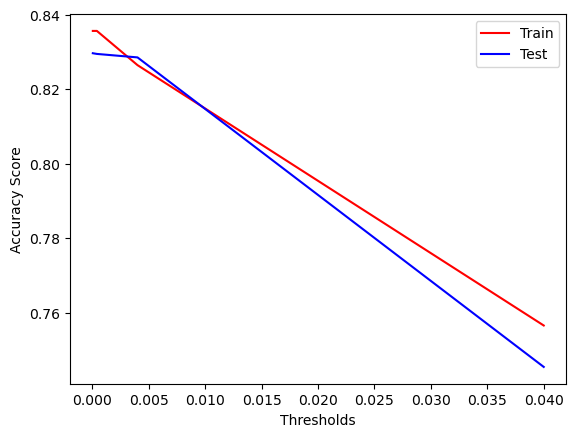

In [30]:
plt.plot(thresholds, train_accuracies_th, label='Train', color='red')
plt.plot(thresholds, test_accuracies_th, label='Test', color = 'blue')
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Accuracy Score')
plt.show()

#### **VT Cross Validation**

It is important to carefully evaluate the performance of the selected features on a validation set or through cross-validation to ensure that the final model is robust and generalizable. Because of this, it will be applied cross validation with the different variance thresholds:

In [31]:
from sklearn.model_selection import cross_val_score

# Define the thresholds to test
thresholds = [0.00004, 0.0004, 0.004, 0.04]

# Create empty lists to store the cv scores
cv_scores = []

# Define the logistic regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# Loop over the thresholds and perform cross-validation
for th in thresholds:
    # Instantiate the VarianceThresholder with the given threshold
    vt = VarianceThreshold(threshold=th)

    # Fit to the data and calculate the variances per column
    vt.fit(X_resampled_ss)

    # Apply the variance threshold to drop columns below the given variance
    X_resampled_th = pd.DataFrame(vt.transform(X_resampled_ss), columns=X_resampled_ss.columns[vt.get_support()])

    # Define the predictor variables
    X_train_th = X_resampled_th

    # Define the target variable
    y_train_th = y_resampled

    # Perform 5-fold cross-validation on the logistic regression model
    cv_score = cross_val_score(logreg, X_train_th, y_train_th, cv=5)
    
    # Append the results
    cv_scores.append(cv_score.mean())

    # Print the average cross-validation score for the current threshold
    print(f"Threshold: {th}, CV Score: {cv_score.mean():.4f}")


Threshold: 4e-05, CV Score: 0.8203
Threshold: 0.0004, CV Score: 0.8203
Threshold: 0.004, CV Score: 0.8182
Threshold: 0.04, CV Score: 0.7550


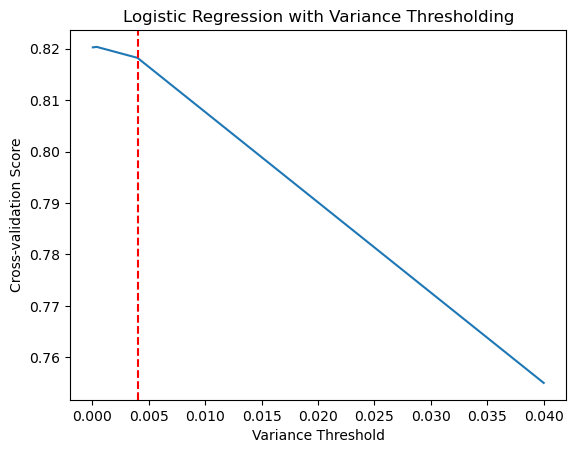

In [32]:
# Plot the cross-validation scores
plt.plot(thresholds, cv_scores)
plt.xlabel('Variance Threshold')
plt.ylabel('Cross-validation Score')
plt.title('Logistic Regression with Variance Thresholding')
plt.axvline(x=0.004, color='r', linestyle='--')
plt.show()

Great! Cross Validation confirm that 0.004 threshold could be a good decision to reduce the number of features and keep model performance.

**Fit the best Variance Threshold to generate the new dataframe with the data downsampled and filter based on varianced threshold.**

In [33]:
# Create a VarianceThreshold object with the BEST threshold value
my_vt = VarianceThreshold(threshold=0.004)

# Fit the VarianceThreshold object to the training data and calculate the variances per column
my_vt.fit(X_resampled_ss)

# Use the VarianceThreshold object to drop columns below the given variance threshold
X_resampled_th = pd.DataFrame(my_vt.transform(X_resampled_ss), columns = X_resampled_ss.columns[my_vt.get_support()])

 # Define the predictor variables for the training and test sets
X_train_th = X_resampled_th
X_test_th = pd.DataFrame(my_vt.transform(X_test_ss), columns = X_test_ss.columns[my_vt.get_support()])

# Define the target variable for the training and test sets
y_train_th = y_resampled
y_test_th = y_test

In [34]:
# Get the shape of the new dataframe post Variance Threshold
X_train_th.shape

(23060, 297)

In [35]:
# Variances
# my_vt.variances_

In [36]:
# Get the columns which are retained
my_vt.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
       False,  True,  True, False, False, False,  True, False,  True,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
        True,  True, False,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,

In [37]:
X_train_th.columns.values

array(['dep_A', 'dep_B', 'dep_C', 'Female', 'Male', 'Divorced', 'Married',
       'Single', 'Widowed', 'Full Time', 'Not Employed', 'Commercial',
       'Medicaid', 'Medicare', 'Car', 'Walk-in', 'ambulance', 'April',
       'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       '03-06', '07-10', '11-14', '15-18', '19-22', '23-02', 'pv_admit',
       'pv_discharge', 'pv_none', 'esi_1', 'esi_2', 'esi_3', 'esi_4',
       'esi_5', 'age', 'n_surgeries', 'cc_abdominalpain',
       'cc_abdominalpainpregnant', 'cc_abnormallab', 'cc_abscess',
       'cc_alcoholintoxication', 'cc_allergicreaction',
       'cc_alteredmentalstatus', 'cc_anxiety', 'cc_armpain',
       'cc_assaultvictim', 'cc_asthma', 'cc_backpain',
       'cc_breathingdifficulty', 'cc_chestpain', 'cc_coldlikesymptoms',
       'cc_cough', 'cc_dentalpain', 'cc_diarrhea', 'cc_dizz

In [38]:
print(f'Applying 0.004 Threshold the final dataframe contains {X_train_th.shape[1]} columns')

Applying 0.004 Threshold the final dataframe contains 297 columns


**Let's confirm how the model perform with the new optimized dataframe**

In [39]:
# Run the model
    
# Create a logistic regression model and fit it to the training data
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
logreg.fit(X_train_th, y_train_th)

# Use the trained model to make predictions on the training and test sets
train_predictions = logreg.predict(X_train_th)
test_predictions = logreg.predict(X_test_th)

# Calculate the accuracy of the model on the training and test sets
train_accuracy_th = logreg.score(X_train_th, y_train_th)
test_accuracy_th = logreg.score(X_test_th, y_test_th)

# Append the training and test accuracies to their respective lists
print(f' The accuracy in the VT train dataframe is {train_accuracy_th}')
print(f' The accuracy in the VT test dataframe is {test_accuracy_th}')

 The accuracy in the VT train dataframe is 0.8264960971379012
 The accuracy in the VT test dataframe is 0.828574990649545


**IMPORTANT:** 
- In comparison with the baseline model, Logistic Regression after applying variance threshold reduce the accuracy in ~ 4% points.
- In comparison with the model after downsampling, Logistic Regression after applying variance threshold reduce the accuracy in ~ 1% points.

Data post Downsampling, Scaling and 0.004 Variance Threshold : 

- X_train_th
- y_train_th
- X_test_th
- y_test_th

### K-best

**Remember the data after downsamplig to keep working with the second option to reduce features: K best**

- X_resampled (original X_train after downsampling)
- y_resampled (original y_train after downsampling)
- X_test
- y_test


Selects Kbest is a module that select features based on their scores using univariate statistical tests. It takes in a scoring function and a number K as parameters, and then returns the K best features according to the given scoring function.

The scoring function can be:

- f_classif for ANOVA F-value
- mutual_info_classif for mutual information score
- chi2 for chi-squared statistic

As the data in this case has a mix of categorical and numeric features, it will be applied mutual_info_classif to obtain mutual information score depending the feature.

#### mutual_info_classif

Mutual info classif takes as input the feature matrix and target variable, and returns an array of scores, one for each feature. The score represents the estimated mutual information between the feature and the target variable, and can be used to rank the features by their importance.

Higher mutual_info_classif scores indicate that the feature is more informative for predicting the target variable, while lower scores indicate that the feature is less informative. 

The scores can be used to select a subset of the most important features for the task at hand, or to gain insights into the relationships between the features and the target variable.

In [40]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_values = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

train_scores = []
test_scores = []

for k in k_values:
    # Select top k features using SelectKBest with mutual information as the score function
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X_resampled, y_resampled)
    X_resampled_top_k = selector.transform(X_resampled)
    X_test_top_k = selector.transform(X_test)
    
    # Train logistic regression model
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    clf.fit(X_resampled_top_k, y_resampled)
    
    # Calculate train and test scores
    train_score = clf.score(X_resampled_top_k, y_resampled)
    test_score = clf.score(X_test_top_k, y_test)
    
    # Append scores to lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"k={k}, train_score={train_score}, test_score={test_score}")


k=100, train_score=0.8171292281006071, test_score=0.8247101358932801
k=150, train_score=0.8197311361665222, test_score=0.827515272409924
k=200, train_score=0.8242844752818733, test_score=0.8305697543947139
k=250, train_score=0.8269731136166523, test_score=0.8284503179154719
k=300, train_score=0.826062445793582, test_score=0.8254581722977185
k=350, train_score=0.8259757155247182, test_score=0.8272035905747414
k=400, train_score=0.8299653078924545, test_score=0.8289490088517641
k=450, train_score=0.8277970511708587, test_score=0.8269542451065952
k=500, train_score=0.8325238508239375, test_score=0.8287619997506546
k=550, train_score=0.8316131830008673, test_score=0.8278892906121431
k=600, train_score=0.8361231569817866, test_score=0.8309437725969331


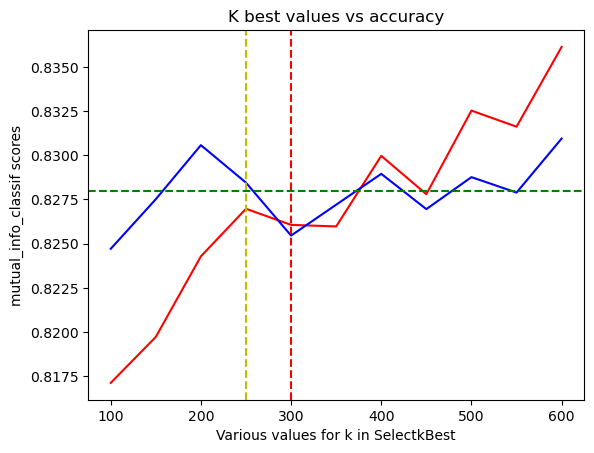

In [41]:
# Visualize the results

plt.plot(k_values, train_scores, label='Train', color='red')
plt.plot(k_values, test_scores, label='Test', color = 'blue')
plt.title('K best values vs accuracy')
plt.xlabel('Various values for k in SelectkBest')
plt.ylabel('mutual_info_classif scores')
plt.axvline(x=300, color='r', linestyle='--')
plt.axvline(x=250, color='y', linestyle='--')
plt.axhline(y=0.828, color='g', linestyle='--')
plt.show()

Comparing Variance threshold and Kbest both options are performing quite similar.

#### Kbest Cross Validation

In [42]:
# Cross Validation to find best Kbest with a higher reduction of features in comparison with Variance threshold

k_values = [150, 200, 250, 300, 350, 400]
best_score = 0
best_k = 0

for k in k_values:
    # Select top k features using SelectKBest with mutual information as the score function
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X_resampled, y_resampled)
    X_resampled_top_k = selector.transform(X_resampled)
    X_test_top_k = selector.transform(X_test)
    
    # Train logistic regression model using 5-fold cross-validation
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    scores = cross_val_score(clf, X_resampled_top_k, y_resampled, cv=5)
    
    # Calculate mean score across all folds
    mean_score = scores.mean()
    
     # Update best score and best k if necessary
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
    
    print(f"k={k}, mean score={mean_score}")
    
print(f"Best k: {best_k}, Best score: {best_score}")


k=150, mean score=0.8166522116218561
k=200, mean score=0.815134431916739
k=250, mean score=0.8174327840416306
k=300, mean score=0.8146574154379879
k=350, mean score=0.8217259323503903
k=400, mean score=0.8197311361665222
Best k: 350, Best score: 0.8217259323503903


Kbest could be good option to reduce features, 250 seems to be a good Kbest.

### PCA 


Principal Component Analysis (PCA) is a way to transform a high-dimensional dataset into a lower-dimensional representation while retaining as much information as possible.

It will be applied over the data obtained after applied Variance Threshold:
- X_train_th
- y_train_th
- X_test_th
- y_test_th


#### PCA Cross Validation (VT df)

In [43]:
from sklearn.decomposition import PCA

# Define range of n_components
n_components = range(1, 300, 5)

# Initialize empty lists to store results
train_scores = []
test_scores = []

# Loop through each value of n_components
for n in n_components:
    
    # Initialize PCA with the given number of components
    pca = PCA(n_components=n)

    # Fit PCA on training data and transform both training and testing data
    X_train_pca = pca.fit_transform(X_train_th)
    X_test_pca = pca.transform(X_test_th)

    # Train a logistic regression model on the transformed training data using 5-fold cross validation
    clf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)
    scores = cross_val_score(clf, X_train_pca, y_train_th, cv=5)

    # Append mean cross-validation score to train_scores and test score to test_scores
    train_scores.append(np.mean(scores))
    test_scores.append(clf.fit(X_train_pca, y_train_th).score(X_test_pca, y_test_th))


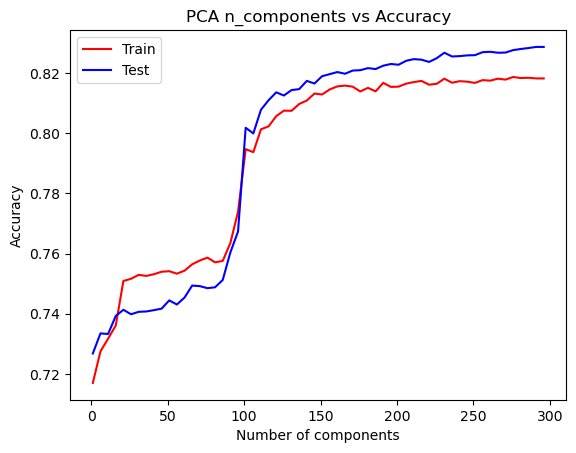

In [44]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(n_components, train_scores, label='Train', color='red')
plt.plot(n_components, test_scores, label='Test', color = 'blue')
plt.title('PCA n_components vs Accuracy')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Looks like over 100 components the train set is underfitting the model. 

## Hiperparameter Optimization (using cross validation)

It will be applied over the data obtained after applied Variance Threshold, no PCA:
- X_train_th
- y_train_th
- X_test_th
- y_test_th

#### Logistic Regression: C value

In [45]:
# Optimizing C value in Logistic Regression and comparing the results the cross validation with test data

c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# initialize lists to store cross-validation and test scores
cv_scores = []
test_scores = []

# loop over different values of C
for c in c_values:
    # initialize logistic regression model with the given value of C
    lr = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1, C=c)
    
    # perform cross-validation on the training set
    cv_score = cross_val_score(lr, X_train_th, y_train_th, cv=5)
    cv_scores.append(cv_score.mean())
    
    # fit the logistic regression model on the training set
    lr.fit(X_train_th, y_train_th)
    
    # calculate the accuracy of the model on the test set
    test_score = lr.score(X_test_th, y_test_th)
    test_scores.append(test_score)


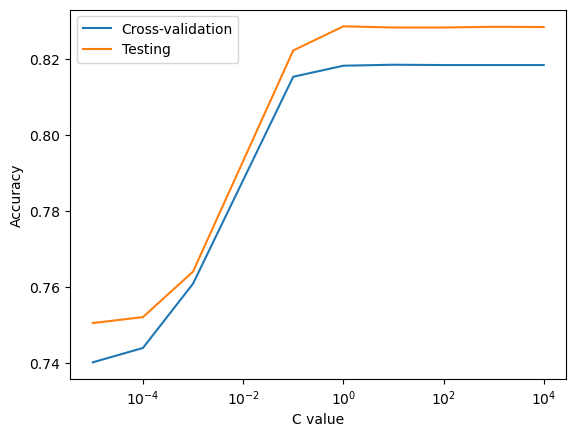

In [46]:
# plot the results of cross-validation and testing
plt.semilogx(c_values, cv_scores, label='Cross-validation')
plt.semilogx(c_values, test_scores, label='Testing')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Decision Trees: Max_depth

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate decision tree models with varying max depths
max_depths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cv_scores = []

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X_train_th, y_train_th, cv=5)
    cv_scores.append(scores.mean())

# Find the best-performing model
best_depth = max_depths[cv_scores.index(max(cv_scores))]
print("Best max depth:", best_depth)

# Train the best-performing model on the full training set
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train_th, y_train_th)

# Evaluate the best-performing model on the test set
test_score = clf.score(X_test_th, y_test_th)
print("Test score:", test_score)



Best max depth: 9
Test score: 0.8173544445829697


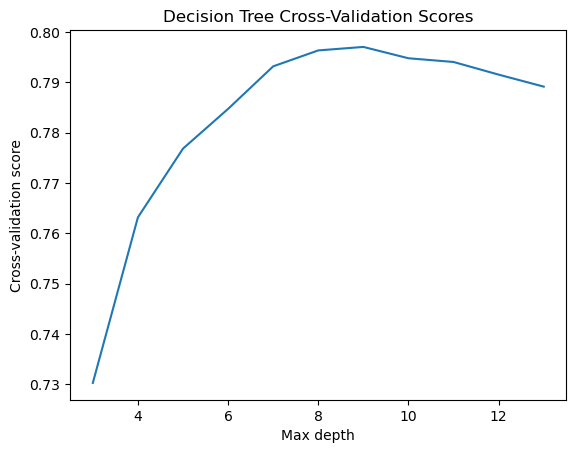

In [48]:
# Plot the results of cross-validation
plt.plot(max_depths, cv_scores)
plt.xlabel("Max depth")
plt.ylabel("Cross-validation score")
plt.title("Decision Tree Cross-Validation Scores")
plt.show()

    

#### Random Forest: n_estimators

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Create an empty list to store the cross validation scores for each n_estimator value
cv_scores = []

# Loop over the n_estimator values and calculate the cross validation score for each
for n in range(10, 201, 10):
    rf = RandomForestClassifier(max_depth=9, n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train_th, y_train_th, cv=5)
    cv_scores.append(scores.mean())


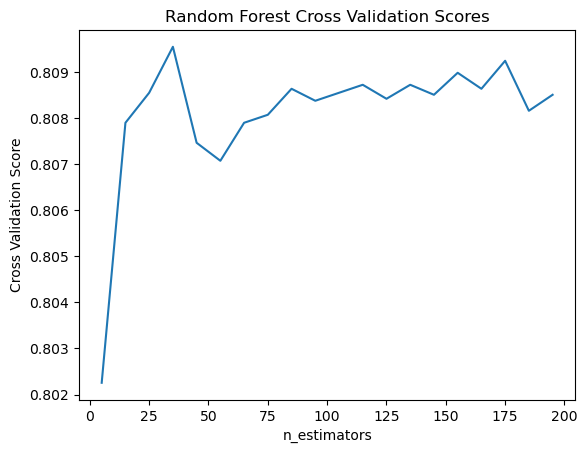

In [50]:
# Plot the results
plt.plot(range(5, 201, 10), cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('Cross Validation Score')
plt.title('Random Forest Cross Validation Scores')
plt.show()


In [51]:
# Find the best n_estimator value
# Train the model with the best n_estimator value and predict on the test set
rf = RandomForestClassifier(max_depth=9, n_estimators=125)
rf.fit(X_train_th, y_train_th)
test_score = rf.score(X_test_th, y_test_th)
print(f'Test set score: {test_score}')


Test set score: 0.8333125545443212


#### XGBoost: n_estimators, max_depth and learning rate

In [52]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define the model with the chosen hyperparameters
xgb_model = xgb.XGBClassifier(max_depth=9, learning_rate=0.3)

# Define the range of n_estimators to try
n_estimators_range = range(100, 200, 10)

# Perform cross-validation on the training set for each value of n_estimators
cv_scores = []
for n_estimators in n_estimators_range:
    xgb_model.set_params(n_estimators=n_estimators)
    scores = cross_val_score(xgb_model, X_train_th, y_train_th, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())



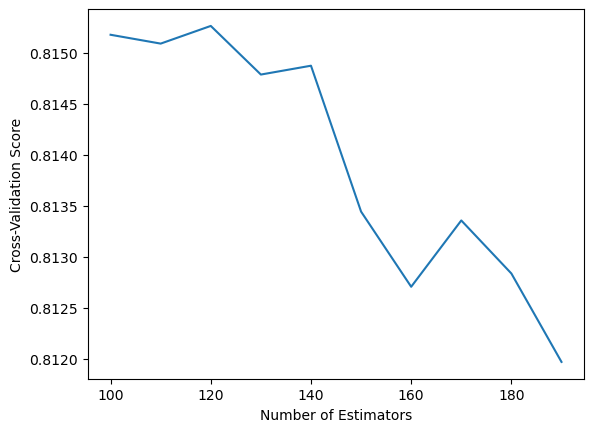

In [53]:
# Plot the results of cross-validation
import matplotlib.pyplot as plt
plt.plot(n_estimators_range, cv_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Score')
plt.show()



In [54]:
# Choose the best n_estimators value based on the cross-validation results
best_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
print(f'The best n_estimator was: {best_n_estimators}')

# Train the XGBoost model on the full training set with the best n_estimators value
xgb_model.set_params(n_estimators=best_n_estimators)
xgb_model.fit(X_train_th, y_train_th)

# Evaluate the model on the test set
test_accuracy = xgb_model.score(X_test_th, y_test_th)
print(f"Test accuracy: {test_accuracy}")


The best n_estimator was: 120
Test accuracy: 0.8238374267547688


## Pipelines

### Logistic Regression Pipe

In [55]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

# Define the pipeline steps
steps = [
    ('sampling', RandomUnderSampler()),  # optional step, to downsample the majority class
    ('variance_threshold', VarianceThreshold(threshold=0.0006)),  # variance thresholding
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)),  # logistic regression model
]

# Define the parameter grid for the pipeline
param_grid = {
    'sampling': [None, RandomUnderSampler()],  # with and without downsampling
    'variance_threshold__threshold': [0.0006, 0.006],  # two different variance thresholds
    'logreg__C': [0.1, 1, 10],  # three different values of C for logistic regression
}

# Define the pipeline object
pipe = Pipeline(steps)

# Run the pipeline with grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 7)
grid.fit(X_train, y_train)

# Evaluate the best pipeline on the test set
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.0006;, score=0.851 total time=  11.0s
[CV 2/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.0006;, score=0.848 total time=  11.2s
[CV 3/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.0006;, score=0.860 total time=  12.0s
[CV 4/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.0006;, score=0.855 total time=  13.2s
[CV 5/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.0006;, score=0.849 total time=  13.7s
[CV 1/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.006;, score=0.849 total time=   7.3s
[CV 2/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.006;, score=0.847 total time=   6.4s
[CV 3/5] END logreg__C=0.1, sampling=None, variance_threshold__threshold=0.006;, score=0.859 total time=   7.1s
[CV 4/5] END logreg__C=0.1, sampling=N

In [56]:
# Get the best pipeline and its parameters
best_pipe = grid.best_estimator_
best_params = grid.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")

Best parameters: {'logreg__C': 0.1, 'sampling': None, 'variance_threshold__threshold': 0.0006}


### Random Forest Pipe

In [71]:
# Define the pipeline steps
steps = [
    ('sampling', RandomUnderSampler()),  # optional step, to downsample the majority class
    ('variance_threshold', VarianceThreshold()),  # variance thresholding
    ('random_forest', RandomForestClassifier())  # random forest model
]

# Define the parameter grid for the pipeline
param_grid = {
    'sampling': [None, RandomUnderSampler()],  # with and without downsampling
    'variance_threshold__threshold': [0.0006, 0.006],  # two different variance thresholds
    'random_forest__max_depth': [8, 9, 10, 11],  # four different max_depth values for random forest
    'random_forest__n_estimators': [100, 150, 200, 250],  # four different n_estimators values for random forest
}

# Define the pipeline object
pipeline = Pipeline(steps=steps)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=7
)

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Evaluate the best pipeline on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.0006;, score=0.827 total time=   1.7s
[CV 2/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.0006;, score=0.827 total time=   1.6s
[CV 3/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.0006;, score=0.832 total time=   1.6s
[CV 4/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.0006;, score=0.834 total time=   1.6s
[CV 5/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.0006;, score=0.827 total time=   1.6s
[CV 1/5] END random_forest__max_depth=8, random_forest__n_estimators=100, sampling=None, variance_threshold__threshold=0.006;, score=0.831 tota

In [ ]:
# Get the best pipeline and its parameters
best_pipeline = grid_search.best_estimator_
best_params = best_pipeline.get_params()

# Print the best parameters
print("Best pipeline parameters:")
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_params[param_name]}")

Best pipeline parameters:
	random_forest__max_depth: 11
	random_forest__n_estimators: 250
	sampling: None
	variance_threshold__threshold: 0.006


### XGBoost Pipe

In [77]:

# Define the pipeline steps
steps = [
    ('undersample', RandomUnderSampler()),
    ('variance_threshold', VarianceThreshold()),
    ('classifier', XGBClassifier())
]

# Define the parameter grid for the pipeline
param_grid = {
    'undersample__sampling_strategy': ['auto'],
    'variance_threshold__threshold': [0.0006, 0.006],
    'classifier__max_depth': [9, 11, 16],
    'classifier__n_estimators': [150, 250, 350],
    'classifier__learning_rate': [0.1, 0.2, 0.3]
}

# Define the pipeline object
pipeline = Pipeline(steps=steps)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose = 7
)

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Evaluate the best pipeline on the test set
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.3f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=9, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.827 total time= 1.1min
[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=9, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.840 total time= 1.5min
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=9, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.817 total time= 2.4min
[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=9, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.829 total time= 2.4min


/Users/ccalderon/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=9, classifier__n_estimators=350, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.840 total time= 3.3min
[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0006;, score=0.827 total time= 3.1min
[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.836 total time= 1.9min
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.832 total time= 3.0min
[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=11, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, s

In [78]:
# Get the best pipeline and its parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters: ", best_params)

Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 150, 'undersample__sampling_strategy': 'auto', 'variance_threshold__threshold': 0.0006}
[CV 1/5] END classifier__learning_rate=0.3, classifier__max_depth=16, classifier__n_estimators=350, undersample__sampling_strategy=auto, variance_threshold__threshold=0.0006;, score=0.815 total time= 9.9min
[CV 4/5] END classifier__learning_rate=0.3, classifier__max_depth=9, classifier__n_estimators=150, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.826 total time= 1.4min
[CV 1/5] END classifier__learning_rate=0.3, classifier__max_depth=9, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.813 total time= 2.3min
[CV 4/5] END classifier__learning_rate=0.3, classifier__max_depth=9, classifier__n_estimators=250, undersample__sampling_strategy=auto, variance_threshold__threshold=0.006;, score=0.823 

In [79]:
grid_search.best_estimator_

Pipeline(steps=[('undersample', RandomUnderSampler()),
                ('variance_threshold', VarianceThreshold(threshold=0.0006)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None,...=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=na

**Preliminar Conclusions**
- About the data included
- A POSSIBILITY TO IMPROVE THE MODEL COULD BE HAS LESS FEATURES GROUPING THE CHIEF COMPLAINS AND PAST MEDICAL HISTORY SITUATIONS.
- About its application and utility in real life
- 

END